In [3]:
import numpy as np
import matplotlib.pyplot as plt
import glob
# from process.jupyter import csvToDict, dataProcess, datasetPlot

In [4]:
# csv to {}
def csvToDict(file):
    dt = {}
    data = []
    header = []
    ready = False
    
    # test file encoding
    enc = 'utf-16-le'
    try:
        with open(file, 'r', encoding=enc) as f:
            for l in f:
                pass
            if 'CAPTURE' not in f.readlines()[:20]:
                enc = None
    except UnicodeDecodeError as e:
        # print(UnicodeDecodeError)
        enc = None    
    
    with open(file, 'r', encoding=enc) as f:
        for line in f:
            if ',' in line:
                if 'index' in line:
                    header = np.array([v for v in line.strip().split(",")[:-1]])
                    # print(header)
                else:
                    data.append([float(v) for v in line.strip().split(",")[:-1]])
    rows = len(data)
    cols = len(header)
    
    # populate empty values with zeroes.
    nump = np.zeros((rows, cols))
    for i in range(rows):
        for j in range(cols):
            try:
                nump[i][j] = data[i][j]
            except IndexError:
                pass
            
    # print(nump.shape)
    # print(nump.T)
    for n, d in zip(header, nump.T):
        dt[n] = d
    dt['name'] = file
    return dt

# post processing csv {} data
def dataProcess(dt):
    dt['time'] = [0]
    for k in dt:
        for i, v in enumerate(dt[k]):
            if k == 'ECL':
                if v > 2:
                    dt[k][i] = -1
            if k == 'idleTime':
                if i > 0:
                    dt['time'].append(v + dt['txTime'][i-1] + dt['time'][i-1])
            else:
                break
    return dt

def dp(dt, length=1000, time=False):
    datasetPlot(dt, length, time)
    
def datasetPlot(dt, length, time):
    h = len(dt[0])/2 + 1
    rainbow = ['g*', 'r*', 'b*', 'y*', 'k*', 'm*', 'c*']
    plt.figure(figsize=(h,h))
    i = 1
    for k in dt[0]:
        if str(type(dt[0][k])) == "<class 'numpy.ndarray'>":
            try:
                # check for data changes
                if len(dt) > 1:
                    diff = np.mean(dt[0][k])
                    for d in dt:
                        if np.mean(d[k]) != diff:
                            break
                        diff = np.mean(d[k])
                    else:
                        continue
            except KeyError:
                pass

            plt.subplot(h,2,i)
            plt.title(k)  
            for j, d in enumerate(dt):
                try:
                    l = min(len(d[k]), length)
                    if time:
                        t = d['time'][:l]
                    else:
                        t = np.arange(0, l, 1)
                    plt.plot(t, d[k][:l], rainbow[j % len(rainbow)])
                except KeyError:
                    pass
            i += 1
    plt.show()

In [119]:
dirr = 'logs/zte_mtn/rf_shield/ublox/'
def mk(files):
    dt = []
    if str(type(files)) == "<class 'str'>":
        files = glob.glob(dirr + files)
    else:
        for i in range(len(files)):
            files[i] = dirr + files[i]
    for f in files:
        dt.append(dataProcess(csvToDict(f)))
    return dt

In [6]:
# dt = mk(['drx/cap/0', 'drx/cap/10', 'drx/cap/20', 'drx/cap/30', 'drx/cap/40', 'drx/cap/s40', 'drx/cap/110_slightly_open'])
dt = mk('drx/cap/*')

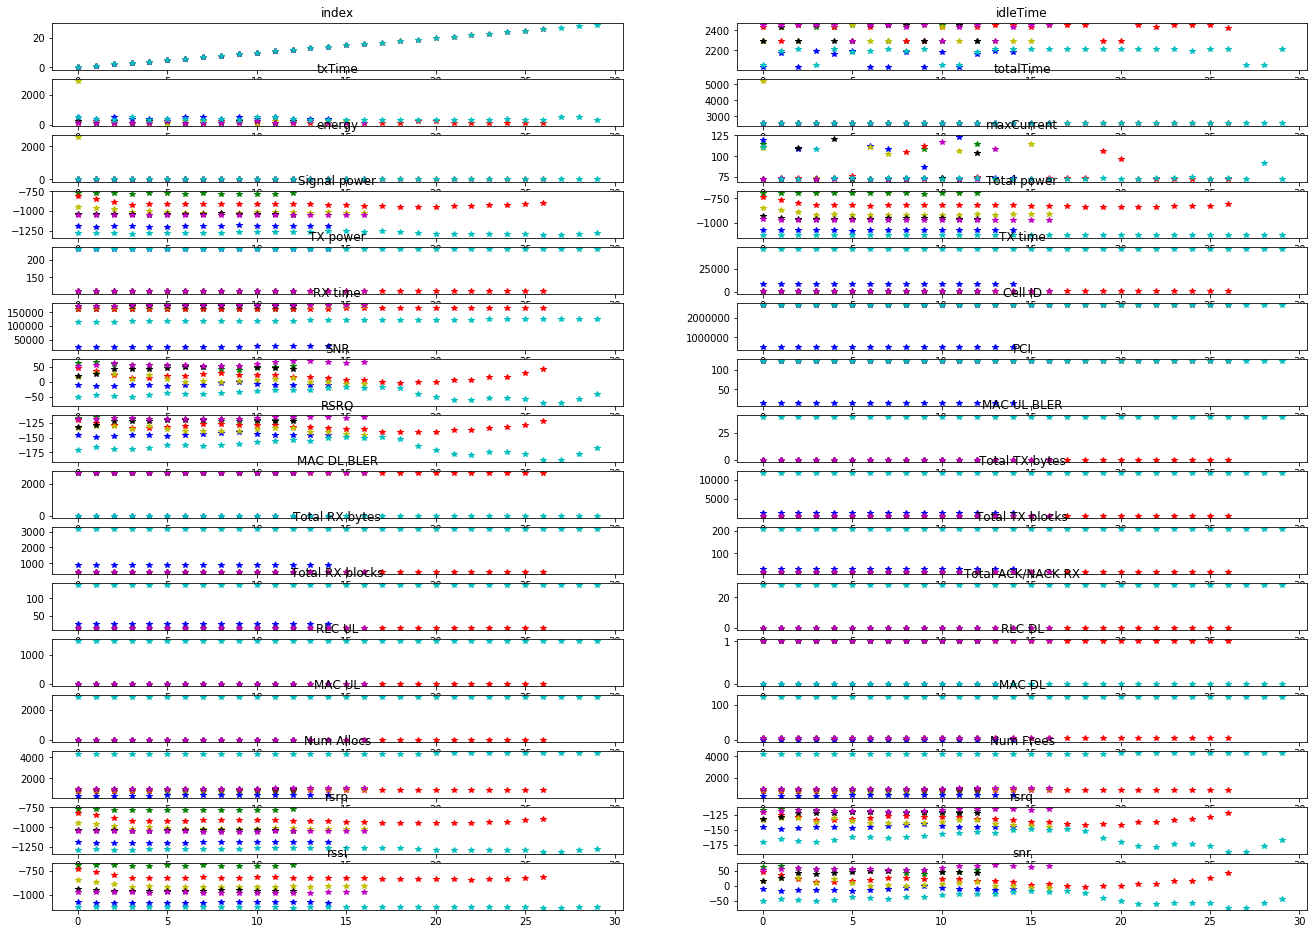

In [7]:
dp(dt)

In [8]:
dt = mk('drx/set/*')
# dp(dt)

In [9]:
dt = mk('release/release1/*')

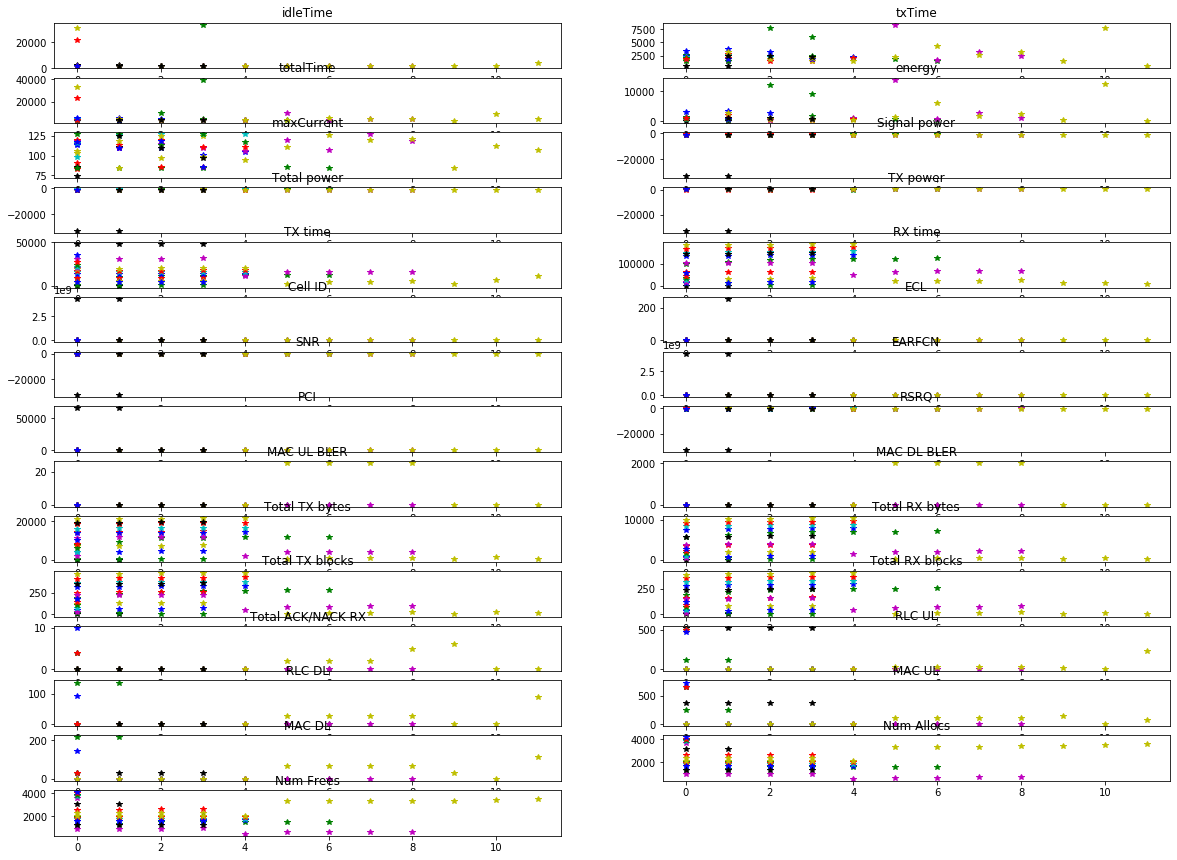

In [10]:
dp(dt)

In [81]:
debug = True

In [12]:
def adjust(key, val):
    if key == 'Signal power':
        return max(-1300, val)
    if key == 'ECL':
        return min(3, val)
    if key == 'SNR':
        return max(-200, val)
    if key == 'txTime':
        if val > 200000:
            return 20000
    return val

In [102]:
def maxHeaders(dt):
    m = 0
    maxH = []
    for d in dt:
        if len(d) > m:
            m = len(d)
            maxH = []
            for k in d:
                if str(type(d[k])) == "<class 'numpy.ndarray'>":
                    maxH.append(k)
    return maxH

In [95]:
def merge(dt):
    merge = {}
    maxH = maxHeaders(dt)
    if debug: 
        print('dt len:', len(maxH))
    for k in maxH:
        merge[k] = []
        for d in dt:
            try:
                for element in d[k]:
                    merge[k].append(adjust(k, element))
            except (KeyError, IndexError) as e:
                if debug: print(e, end=",")
    return merge

mg = merge(dt) 
# for k in mg:
#     print(k, mg[k])

dt len: 36


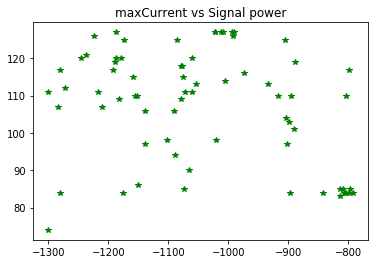

In [68]:
# plt.figure()
plt.title('maxCurrent vs Signal power')
plt.plot(mg['Signal power'], mg['maxCurrent'], 'g*')

In [15]:
def mean(dt):
    mean = {}
    if debug: 
        print('dt len:', len(dt[0]))
    for k in dt[0]:
        if str(type(dt[0][k])) == "<class 'numpy.ndarray'>":
            mean[k] = []
            for d in dt:
                mean[k].append(adjust(k, np.mean(d[k])))
    return mean

mn = mean(dt)
for k in mn:
    print(k, mn[k])

index [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
idleTime [1594.4285714285713, 6700.25, 1423.0, 9003.5, 2034.5, 1543.4444444444443, 1494.0, 9733.25, 1554.6, 1594.25, 1687.1666666666667, 1523.0, 1389.0, 1407.0, 1391.0, 1696.0, 1712.0]
txTime [1971.7142857142858, 1719.25, 2408.8, 1736.5, 525.5, 2776.222222222222, 2289.4, 4206.75, 2157.2, 2245.75, 2742.5833333333335, 2257.75, 1892.0, 1792.0, 2006.0, 1908.0, 3408.0]
totalTime [3566.1428571428573, 8419.5, 3831.8, 10740.0, 2560.0, 4319.666666666667, 3783.4, 13940.0, 3711.8, 3840.0, 4429.75, 3780.75, 3281.0, 3199.0, 3397.0, 3604.0, 5120.0]
energy [827.1885714285715, 588.6225, 1303.992, 537.415, 29.865000000000002, 2396.222222222222, 985.8100000000001, 5549.3475, 943.4200000000001, 1186.405, 2439.370833333334, 845.4100000000001, 587.43, 571.23, 698.34, 915.09, 3117.93]
maxCurrent [88.85714285714286, 90.75, 107.6, 102.25, 92.5, 114.55555555555556, 121.0, 123.75, 109.0, 106.75, 110.16666666666667, 104.2

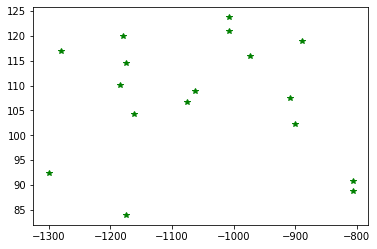

In [16]:
plt.plot(mn['Signal power'], mn['maxCurrent'], 'g*')

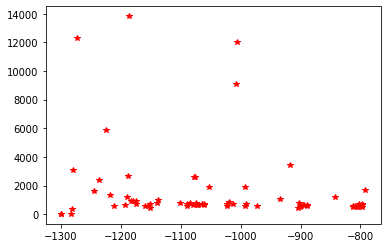

In [17]:
plt.plot(mg['Signal power'], mg['energy'], 'r*')

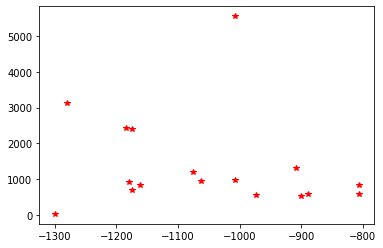

In [18]:
plt.plot(mn['Signal power'], mn['energy'], 'r*')

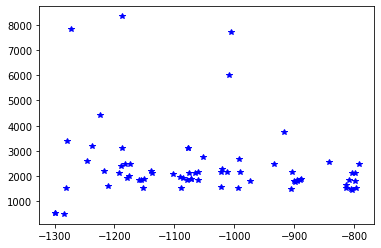

In [19]:
plt.plot(mg['Signal power'], mg['txTime'], 'b*')

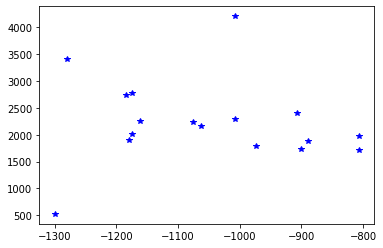

In [20]:
plt.plot(mn['Signal power'], mn['txTime'], 'b*')

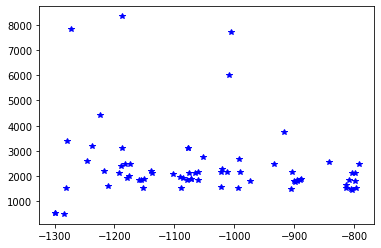

In [21]:
plt.plot(mg['Signal power'], mg['txTime'], 'b*')

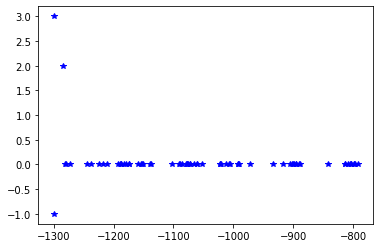

In [22]:
plt.plot(mg['Signal power'], mg['ECL'], 'b*')

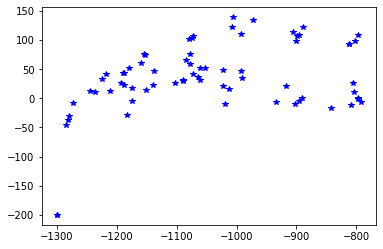

In [23]:
plt.plot(mg['Signal power'], mg['SNR'], 'b*')

In [126]:
def latency_vs_rsrp(files, colour):
    for f in files:
        zu_mg = merge(mk(f))
        plt.plot(np.array(zu_mg['Signal power'])/10, np.array(zu_mg['txTime'])/1000, colour)

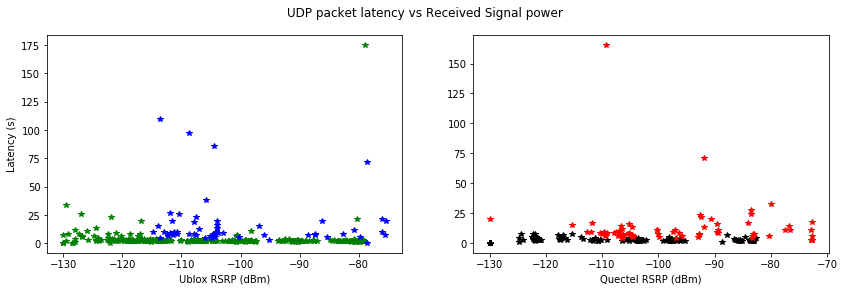

In [128]:
fx = 14
fy = 4
sx = 1
sy = 2
debug = False
plt.figure(figsize=(fx, fy))
plt.suptitle('UDP packet latency vs Received Signal power')

files = ['release/release0/*','release/release1/*','release/release16/*','release/release64/*','release/release128/*','release/release256/*','release/release512/*']

plt.subplot(sx, sy, 1)
plt.xlabel('Ublox RSRP (dBm)')
plt.ylabel('Latency (s)')
dirr = 'logs/zte_mtn/rf_shield/ublox/'
latency_vs_rsrp(files, 'g*')
dirr = 'logs/nokia_vodacom/centurycity/ublox/'
latency_vs_rsrp(files, 'b*')

plt.subplot(sx, sy, 2)
plt.xlabel('Quectel RSRP (dBm)')
dirr = 'logs/zte_mtn/rf_shield/quectel/'
latency_vs_rsrp(files[1:], 'k*')
dirr = 'logs/nokia_vodacom/centurycity/quectel/'
latency_vs_rsrp(files[1:], 'r*')

plt.savefig('img/vodacom_vs_mtn_latency.png')
plt.show()